In [1]:
# Install geopy for geocoding functionality (run in notebook or terminal)
!pip install geopy 

In [2]:
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from decimal import Decimal
import urllib.request
import time
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

# Solar panel parameters
panel_efficiency = 0.18  # Efficiency (18%)
panel_area = 1.6         # Area per panel (m²)

# Dictionary of phone models and their battery capacities (mAh)
phones = {
    "iPhone 15 Pro Max": 4422,
    "Nothing Phone (2)": 4700,
    "Xiaomi 14 Pro": 4880,
    "Samsung Galaxy S25 Ultra": 5000
}

def get_center_coordinates(place_name: str):
    """
    Returns the latitude and longitude for a given place name using geopy.
    Raises ValueError if the location cannot be found.
    """
    geolocator = Nominatim(user_agent="geo_center_finder")
    location = geolocator.geocode(place_name, timeout=10)
    if location:
        return (location.latitude, location.longitude)
    else:
        raise ValueError(f"Could not find coordinates for '{place_name}'")

def get_coords_from_input(place_name: str):
    """
    Parses user input for coordinates or place name and returns (latitude, longitude).
    """
    center = None
    # Check if input is coordinates in parentheses or brackets
    if (place_name.startswith("(") and place_name.endswith(")")) or (place_name.startswith("[") and place_name.endswith("]")):
        center = (Decimal(place_name.split(",")[0].strip("()[]")), Decimal(place_name.split(",")[1].strip("()[]")))
    else:
        center = get_center_coordinates(place_name)
    print(f"Center of {place_name}: {center}")
    return center

# Prompt user for location input and retrieve coordinates
place_name = input("Enter a place name (Disneyland), address (11122 NE 180th St, Bothell, WA 98011) or a set of coordinates in parentheses (47.65597163427398, -122.30944207919211): ")
center = get_coords_from_input(place_name)
latitude, longitude = center

# Optionally allow user to add a custom phone battery capacity
custom_phone_battery = input("Optional: Enter your phone battery capacity in mAh (or press Enter to skip): ")
custom_phone_name = ""
if custom_phone_battery:
    custom_phone_name = input("Optional: Enter your phone name (or press Enter to skip): ") or "Custom Phone"
    phones.update({custom_phone_name: int(custom_phone_battery)})

# Sort phones by battery capacity in descending order
phones = dict(sorted(phones.items(), key=lambda item: item[1], reverse=True))

Center of seattle: (47.6038321, -122.330062)


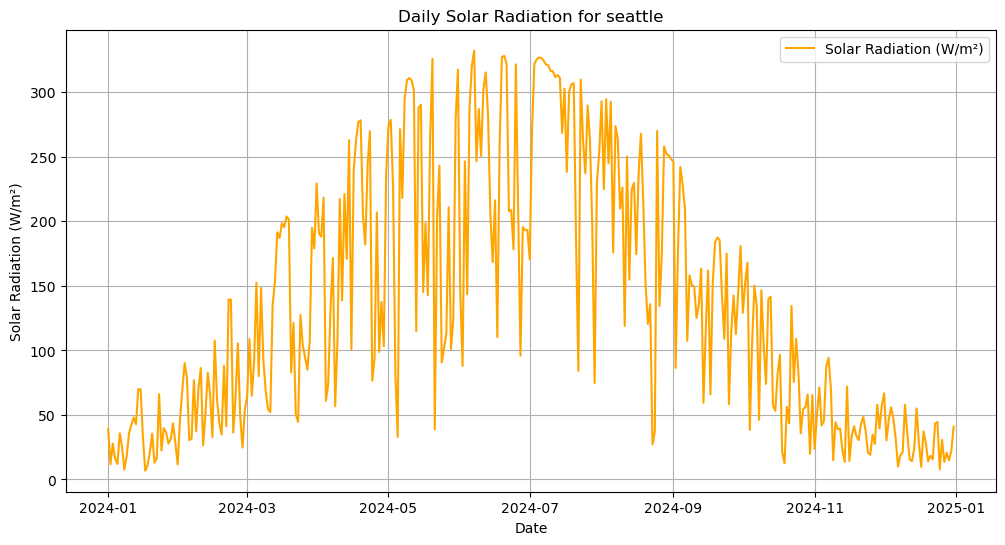

Minimum Solar Radiation: 6.8 W/m²
Maximum Solar Radiation: 332.2 W/m²


In [3]:
# Retrieve and process weather data for the specified coordinates and date range

api_key = '298LYYNTAZVEU5JN67C8W5AQE'  # Visual Crossing API key

def get_weather_data(lat, lon, start_date, end_date, api_key):
    """
    Fetches daily solar radiation data from the Visual Crossing API for the given location and date range.
    """
    url = (
        f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{start_date}/{end_date}'
        '?unitGroup=metric&elements=datetimeEpoch,solarradiation'
        f'&key={api_key}&contentType=json'
    )
    response = urllib.request.urlopen(url).read()
    data = json.loads(response)
    return data

def convert_to_dataframe(weather_data):
    """
    Converts weather data JSON to a pandas DataFrame with date and solar radiation columns.
    """
    records = []
    for day in weather_data['days']:
        record = {
            'date': datetime.fromtimestamp(day['datetimeEpoch']),
            'solar_radiation': day.get('solarradiation', 0)
        }
        records.append(record)
    df = pd.DataFrame(records)
    df.set_index('date', inplace=True)
    return df

def plot_solar_radiation(df):
    """
    Plots daily solar radiation values for the selected location.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['solar_radiation'], label='Solar Radiation (W/m²)', color='orange')
    plt.title('Daily Solar Radiation for ' + place_name)
    plt.xlabel('Date')
    plt.ylabel('Solar Radiation (W/m²)')
    plt.grid()
    plt.legend()
    plt.show()

def calculate_solar_panels_needed(solar_radiation_watts, panel_efficiency, panel_area, phone_capacity_mah):
    """
    Calculates the number of solar panels required to fully charge a phone in one day.
    """
    solar_radiation_kw = solar_radiation_watts / 1000
    phone_capacity_kwh = (phone_capacity_mah * 3.7) / 1000000  # Convert mAh to kWh
    energy_per_panel_per_day = solar_radiation_kw * panel_efficiency * panel_area  # kWh/day
    if energy_per_panel_per_day == 0:
        return float('inf')  # Avoid division by zero
    panels_needed = phone_capacity_kwh / energy_per_panel_per_day
    return panels_needed

# Fetch and plot solar radiation data for 2024
weather_data = get_weather_data(latitude, longitude, '2024-01-01', '2024-12-31', api_key)
df = convert_to_dataframe(weather_data)
plot_solar_radiation(df)

# Display minimum and maximum solar radiation values
min_solar_radiation = df['solar_radiation'].min()
max_solar_radiation = df['solar_radiation'].max()
print(f"Minimum Solar Radiation: {min_solar_radiation} W/m²")
print(f"Maximum Solar Radiation: {max_solar_radiation} W/m²")

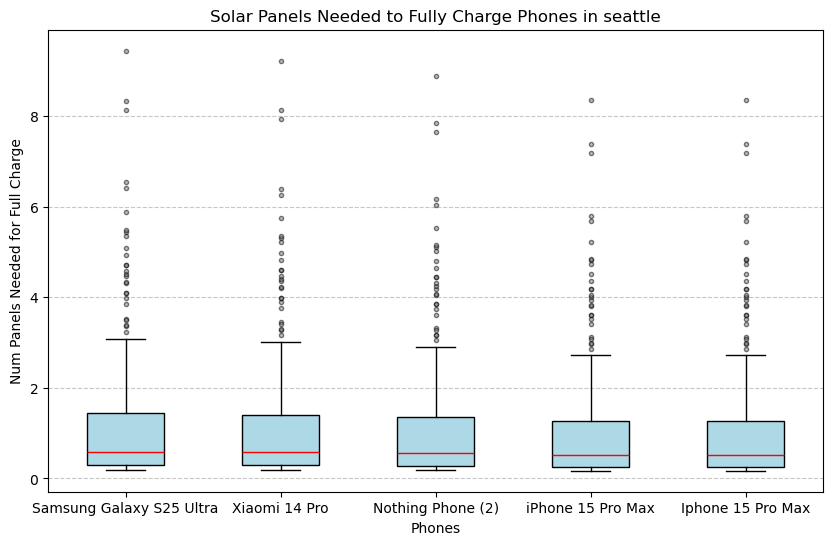

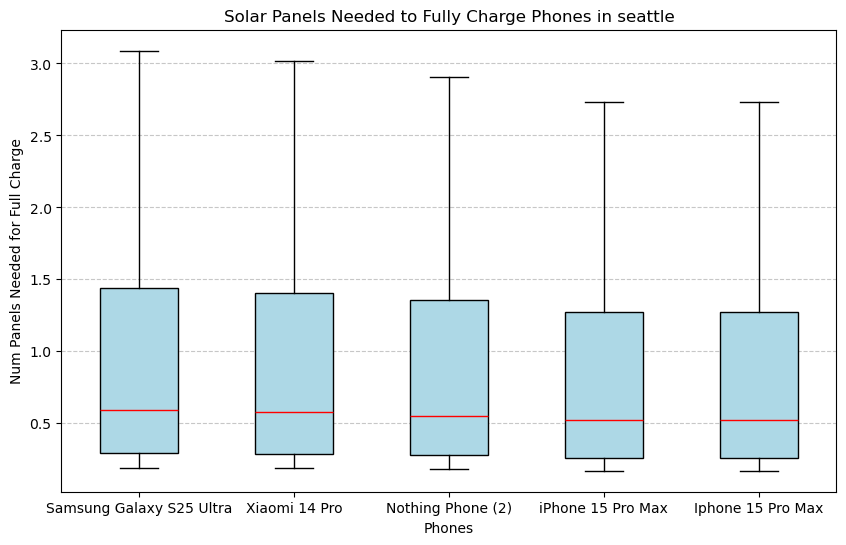

In [4]:
# Plot a graph of the number of panels needed for each phone, as a box and  whisker plot
# The graph should show a total of 3 box plots, one for each pheon
# the maximum and minimum number of panels needed for each phone
# as well as the median, Q1 and Q3 values
def plot_box_and_whisker_full(df, phones, panel_efficiency=0.18, panel_area=1.6, show_outliers=True):
    """
    Draws a box-and-whisker plot for each phone, showing the distribution of solar panels
    needed per day throughout the year.
    
    Parameters:
    - df: DataFrame with daily solar radiation (must include column 'solar_radiation')
    - phones: dict with phone names and battery capacities (in mAh)
    - panel_efficiency: efficiency of solar panels (default 18%)
    - panel_area: area of a single panel in square meters (default 1.6 m²)
    """
    phone_data = {}

    for phone, capacity in phones.items():
        phone_capacity_kwh = (capacity * 3.7) / 1_000_000
        energy_per_panel_per_day = (df['solar_radiation'] / 1000) * panel_efficiency * panel_area
        panels_needed = phone_capacity_kwh / energy_per_panel_per_day.replace(0, float('nan'))  # Avoid /0
        phone_data[phone] = panels_needed

    # Creates a boxplot
        flierprops = dict(marker='o', markersize=3, linestyle='none', markerfacecolor='gray', alpha=0.5)

    plt.figure(figsize=(10, 6))
    if (show_outliers):
        plt.boxplot(phone_data.values(), tick_labels=phone_data.keys(), patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                flierprops=flierprops,
                showfliers=True)
    else:
        plt.boxplot(phone_data.values(), tick_labels=phone_data.keys(), patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                showfliers=False)
    

    plt.title(f"Solar Panels Needed to Fully Charge Phones in {place_name}")
    plt.ylabel("Num Panels Needed for Full Charge")
    plt.xlabel("Phones")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_box_and_whisker_full(df, phones, panel_efficiency, panel_area, show_outliers=True)
plot_box_and_whisker_full(df, phones, panel_efficiency, panel_area, show_outliers=False)

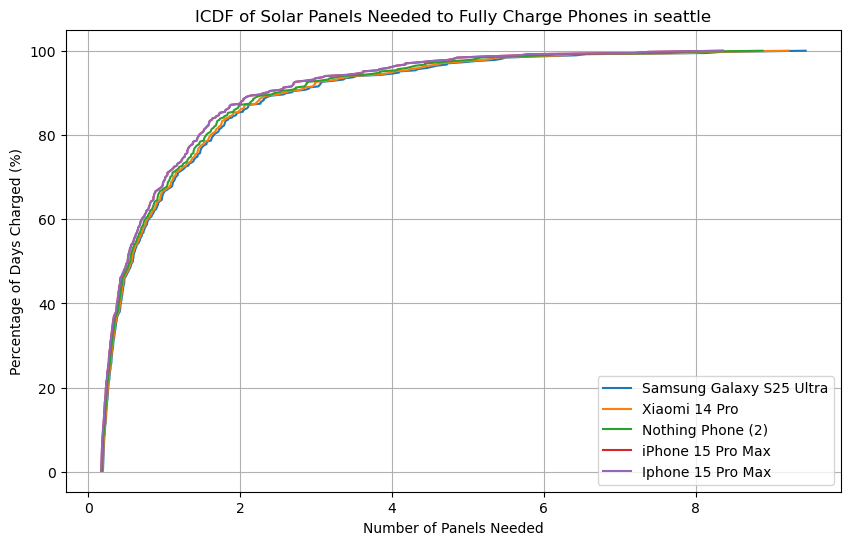

In [5]:
# # Plot the inverse cumulative distribution function (ICDF) for panels needed per phone
# X-axis: Number of solar panels
# Y-axis: Percentage of days where the battery would be fully charged

def plot_icdf(df, phones, panel_efficiency=0.18, panel_area=1.6):
    """
    Plots the Inverse Cumulative Distribution Function (ICDF) for the number of solar panels needed
    to fully charge each phone, showing the percentage of days where the battery would be fully charged.
    
    Parameters:
    - df: DataFrame with daily solar radiation (must include column 'solar_radiation')
    - phones: dict with phone names and battery capacities (in mAh)
    - panel_efficiency: efficiency of solar panels (default 18%)
    - panel_area: area of a single panel in square meters (default 1.6 m²)
    """
    phone_data = {}

    for phone, capacity in phones.items():
        phone_capacity_kwh = (capacity * 3.7) / 1_000_000
        energy_per_panel_per_day = (df['solar_radiation'] / 1000) * panel_efficiency * panel_area
        panels_needed = phone_capacity_kwh / energy_per_panel_per_day.replace(0, float('nan'))  # Avoid /0
        phone_data[phone] = panels_needed

    # Calculate ICDF
    icdf_data = {}
    for phone, panels in phone_data.items():
        sorted_panels = sorted(panels.dropna())
        percentiles = [(i + 1) / len(sorted_panels) * 100 for i in range(len(sorted_panels))]
        icdf_data[phone] = pd.Series(percentiles, index=sorted_panels)

    # Plot ICDF
    plt.figure(figsize=(10, 6))
    for phone, icdf in icdf_data.items():
        plt.plot(icdf.index, icdf.values, label=phone)

    plt.title(f"ICDF of Solar Panels Needed to Fully Charge Phones in {place_name}")
    plt.xlabel("Number of Panels Needed")
    plt.ylabel("Percentage of Days Charged (%)")
    plt.grid()
    plt.legend()
    plt.show()
# Plot the ICDF for all phones
plot_icdf(df, phones, panel_efficiency, panel_area)

In [6]:
# Calculate and display the percentage of days each phone would be fully charged with a given number of panels

def percentage_of_days_fully_charged(df, phones, panel_efficiency=0.18, panel_area=1.6, num_panels=1):
    """
    Calculates the percentage of days each phone would be fully charged with a given number of solar panels.
    Returns a dictionary with phone names as keys and percentage values.
    """
    percentages = {}
    for phone, capacity in phones.items():
        phone_capacity_kwh = (capacity * 3.7) / 1_000_000
        energy_per_panel_per_day = (df['solar_radiation'] / 1000) * panel_efficiency * panel_area
        total_energy_available = energy_per_panel_per_day * num_panels
        days_fully_charged = (total_energy_available >= phone_capacity_kwh).sum()
        total_days = len(df)
        percentage = (days_fully_charged / total_days) * 100
        percentages[phone] = percentage
    return percentages

def write_percentage_of_days_fully_charged(df, phones, panel_efficiency=0.18, panel_area=1.6, num_panels=1):
    """
    Prints the percentage of days each phone would be fully charged with the specified number of panels.
    """
    percentage_fully_charged = percentage_of_days_fully_charged(df, phones, panel_efficiency, panel_area, num_panels)
    panel_name = "panel" if num_panels == 1 else "panels"
    print(f"\nPercentage of Days Fully Charged with {num_panels} {panel_name} in {place_name}:")
    for phone, percentage in percentage_fully_charged.items():
        display_phone = str(phone).ljust(30)
        display_percentage = Decimal(percentage).quantize(Decimal('0.01'))
        display_percentage = (str(display_percentage) + "% of the time").ljust(30)
        display_days = Decimal(percentage / 100 * 365).quantize(Decimal('0'))
        display_days = (str(display_days) + " days a year").ljust(30)
        print(f" - The {display_phone} {display_percentage} {display_days}")

# Display results for 1, 2, and 3 panels
write_percentage_of_days_fully_charged(df, phones, panel_efficiency, panel_area, num_panels=1)
write_percentage_of_days_fully_charged(df, phones, panel_efficiency, panel_area, num_panels=2)
write_percentage_of_days_fully_charged(df, phones, panel_efficiency, panel_area, num_panels=3)


Percentage of Days Fully Charged with 1 panel in seattle:
 - The Samsung Galaxy S25 Ultra       66.39% of the time             242 days a year               
 - The Xiaomi 14 Pro                  66.67% of the time             243 days a year               
 - The Nothing Phone (2)              67.21% of the time             245 days a year               
 - The iPhone 15 Pro Max              68.85% of the time             251 days a year               
 - The Iphone 15 Pro Max              68.85% of the time             251 days a year               

Percentage of Days Fully Charged with 2 panels in seattle:
 - The Samsung Galaxy S25 Ultra       85.25% of the time             311 days a year               
 - The Xiaomi 14 Pro                  85.79% of the time             313 days a year               
 - The Nothing Phone (2)              87.16% of the time             318 days a year               
 - The iPhone 15 Pro Max              87.16% of the time             318 days a y